# OULAD : Clustering pour Identifier les Profils d'Étudiants

Ce notebook effectue une analyse de clustering sur le jeu de données Open University Learning Analytics Dataset (OULAD) pour identifier des profils d'étudiants, en particulier ceux à risque d'abandon scolaire (ceux qui abandonnent ou échouent). Les algorithmes utilisés sont **K-Means** et **DBSCAN**, avec des visualisations pour interpréter les clusters et leurs caractéristiques, en mettant l'accent sur les facteurs liés au risque d'abandon.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [7]:
df = pd.read_csv('oulad_preprocessed.csv')

## Clustering avec K-Means

Appliquer l'algorithme K-Means pour identifier 3 groupes d'étudiants et analyser leurs profils.

In [12]:
def preparer_donnees_clustering(df):
    # Caractéristiques sélectionnées
    features = ['gender', 'highest_education', 'imd_band', 'age_band', 'score', 'total_clicks']
    
    # Sous-ensemble des colonnes
    X = df[features].copy()
    
    # Encodage one-hot des variables catégorielles
    cat_cols = X.select_dtypes(include=['object']).columns
    X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    
    # Reconstruction du DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)
    X_scaled_df['id_student'] = df['id_student'].values
    X_scaled_df['at_risk'] = df['at_risk'].values
    
    # Export CSV
    X_scaled_df.to_csv('oulad_clustering_ready.csv', index=False)
    print('✅ Données préparées pour le clustering sauvegardées sous oulad_clustering_ready.csv')
    
    return X_scaled_df


X_scaled_df = preparer_donnees_clustering(df)
X_scaled_df.head()

✅ Données préparées pour le clustering sauvegardées sous oulad_clustering_ready.csv


,gender,highest_education,imd_band,score,total_clicks,age_band_35-55,age_band_55<=,id_student,at_risk
0,-0.907405,1.681820,1.730308,0.633425,-0.166102,-0.638198,12.243101,11391,0
1,1.102043,1.681820,-0.799144,-0.436950,0.129896,1.566911,-0.081679,28400,0
2,1.102043,0.347751,-0.437794,0.000000,-0.551904,1.566911,-0.081679,30268,1
3,1.102043,0.347751,0.284907,0.221742,0.557055,1.566911,-0.081679,31604,0
4,1.102043,-0.986318,0.284907,-1.260315,-0.107021,-0.638198,-0.081679,32885,0


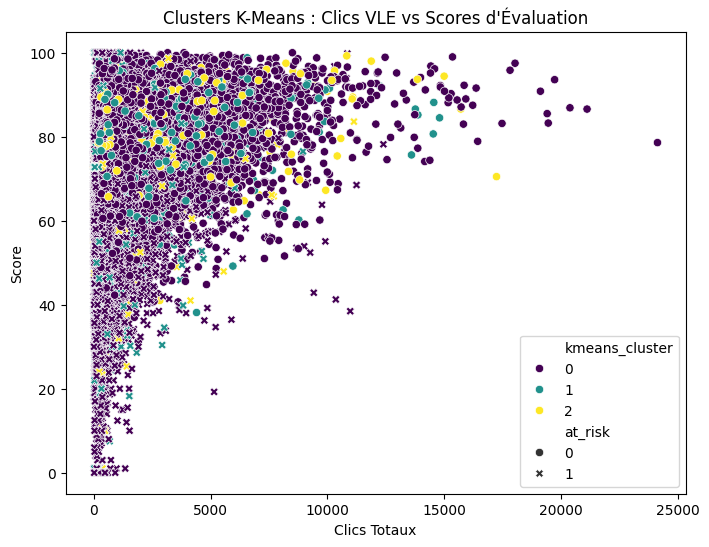

Résumé des Clusters K-Means :
                  gender  highest_education   imd_band      score  \
kmeans_cluster                                                      
0               0.452063           1.724731  41.762212  72.658882   
1               0.468962           1.818305  43.403073  73.152411   
2               0.406034           1.956897  48.566649  74.792957   

                total_clicks   at_risk  count  
kmeans_cluster                                 
0                1187.630055  0.531616  29226  
1                1336.428183  0.507476   2207  
2                1677.522414  0.475000   1160  


In [14]:
# Appliquer K-Means
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled_df)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='total_clicks', y='score', hue='kmeans_cluster', style='at_risk', palette='viridis')
plt.title('Clusters K-Means : Clics VLE vs Scores d\'Évaluation')
plt.xlabel('Clics Totaux')
plt.ylabel('Score')
plt.show()

# Résumer les caractéristiques des clusters
kmeans_summary = df.groupby('kmeans_cluster').agg({
    'gender': 'mean',
    'highest_education': 'mean',
    'imd_band': 'mean',
    'score': 'mean',
    'total_clicks': 'mean',
    'at_risk': 'mean',
    'id_student': 'count'
}).rename(columns={'id_student': 'count'})
print('Résumé des Clusters K-Means :')
print(kmeans_summary)

## Clustering avec DBSCAN

Appliquer l'algorithme DBSCAN pour identifier des clusters et des points aberrants, en mettant l'accent sur les étudiants à risque.

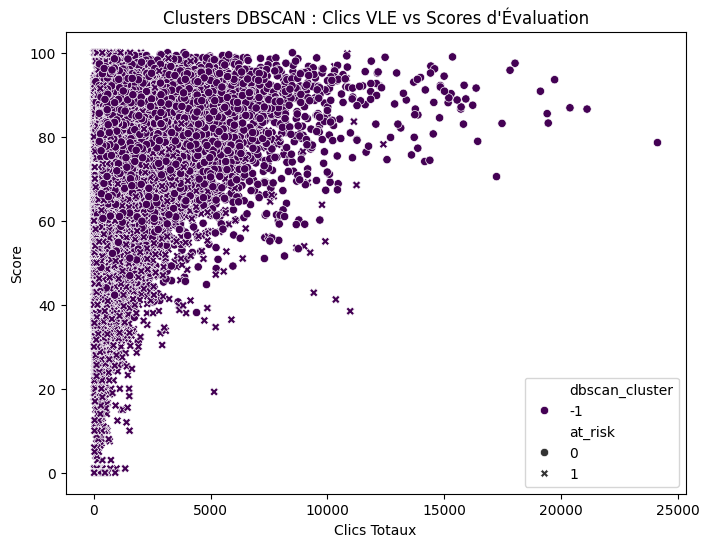

Résumé des Clusters DBSCAN (excluant les points aberrants) :
Empty DataFrame
Columns: [gender, highest_education, imd_band, score, total_clicks, at_risk, count]
Index: []
Nombre de points aberrants (DBSCAN) : 32593
Taux d'abandon parmi les points aberrants : 0.527966127696131


In [16]:
# Appliquer DBSCAN
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled_df)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='total_clicks', y='score', hue='dbscan_cluster', style='at_risk', palette='viridis')
plt.title('Clusters DBSCAN : Clics VLE vs Scores d\'Évaluation')
plt.xlabel('Clics Totaux')
plt.ylabel('Score')
plt.show()

# Résumer les caractéristiques des clusters
dbscan_summary = df[df['dbscan_cluster'] != -1].groupby('dbscan_cluster').agg({
    'gender': 'mean',
    'highest_education': 'mean',
    'imd_band': 'mean',
    'score': 'mean',
    'total_clicks': 'mean',
    'at_risk': 'mean',
    'id_student': 'count'
}).rename(columns={'id_student': 'count'})
print('Résumé des Clusters DBSCAN (excluant les points aberrants) :')
print(dbscan_summary)

# Analyse des points aberrants
outliers = df[df['dbscan_cluster'] == -1]
print('Nombre de points aberrants (DBSCAN) :', len(outliers))
print('Taux d\'abandon parmi les points aberrants :', outliers['at_risk'].mean())

## Analyse des Profils à Risque

Interpréter les clusters pour identifier les profils d'étudiants à risque.

In [17]:
# Profils à risque dans K-Means
print('Analyse des Profils à Risque (K-Means) :')
high_risk_kmeans = kmeans_summary[kmeans_summary['at_risk'] > kmeans_summary['at_risk'].mean()]
print('Clusters à haut risque (K-Means) :')
print(high_risk_kmeans)

# Profils à risque dans DBSCAN
print('\nAnalyse des Profils à Risque (DBSCAN) :')
if not dbscan_summary.empty:
    high_risk_dbscan = dbscan_summary[dbscan_summary['at_risk'] > dbscan_summary['at_risk'].mean()]
    print('Clusters à haut risque (DBSCAN) :')
    print(high_risk_dbscan)
else:
    print('Aucun cluster DBSCAN formé (ajustez eps et min_samples si nécessaire).')

# Résumé des points aberrants à risque
print('\nRésumé des Points Aberrants à Risque (DBSCAN) :')
if len(outliers) > 0:
    print('Caractéristiques des points aberrants :')
    print(outliers[['gender', 'highest_education', 'imd_band', 'score', 'total_clicks', 'at_risk']].mean())
else:
    print('Aucun point aberrant détecté.')

Analyse des Profils à Risque (K-Means) :
Clusters à haut risque (K-Means) :
                  gender  highest_education   imd_band      score  \
kmeans_cluster                                                      
0               0.452063           1.724731  41.762212  72.658882   
1               0.468962           1.818305  43.403073  73.152411   

                total_clicks   at_risk  count  
kmeans_cluster                                 
0                1187.630055  0.531616  29226  
1                1336.428183  0.507476   2207  

Analyse des Profils à Risque (DBSCAN) :
Aucun cluster DBSCAN formé (ajustez eps et min_samples si nécessaire).

Résumé des Points Aberrants à Risque (DBSCAN) :
Caractéristiques des points aberrants :
gender                  0.451569
highest_education       1.739331
imd_band               42.115495
score                  72.768254
total_clicks         1215.141257
at_risk                 0.527966
dtype: float64
